In [39]:
print(torch.version.cuda)
print(torch.__version__) 
print(torch.cuda.is_available()) 
print(torch.cuda.device_count())

10.2
1.6.0
True
1


## Try to create a directed graph

In [40]:
import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
%matplotlib inline
import matplotlib.pyplot as plt

In [55]:
# Create a graph
x = torch.tensor([[2,1],[5,6],[3,7],[12,0]],dtype=torch.float) # 4 nodes
y = torch.tensor([0,1,0,1],dtype=torch.float)       # nodes' label

# For edge_index, first list is the source, second list is destination
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

data = Data(x=x,y=y,edge_index=edge_index)
print(data)

G = to_networkx(data, to_undirected=False) # directed graph

Data(edge_index=[2, 5], x=[4, 2], y=[4])


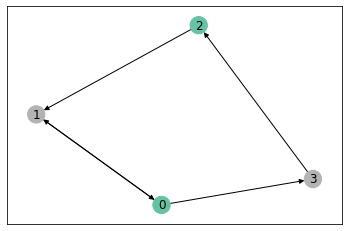

In [56]:
h = G
color = data.y
if torch.is_tensor(h): 
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
else: 
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42),
                         node_color=color, cmap="Set2")
plt.show()

## Example : RecSys Challenge 2015
主要目的是创建一个 session-based recommender system，主要任务有两个：<br/>
1.预测经过一系列的点击后，是否会产生购买行为<br/>
2.预测购买的商品

In [61]:
import numpy as np
import pandas as pd

from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [62]:
np.random.seed(20)

### Test data (點擊數據)

In [63]:
df = pd.read_csv('D:\yoochoose-data\\yoochoose-clicks.dat',header=None) # 33003944 rows × 4 columns
df.columns=['session_id','timestamp','item_id','category']
df.head()

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


In [171]:
# Label encode
item_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head() 

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,2053,0
1,1,2014-04-07T10:54:09.868Z,2052,0
2,1,2014-04-07T10:54:46.998Z,2054,0
3,1,2014-04-07T10:57:00.306Z,9876,0
4,2,2014-04-07T13:56:37.614Z,19448,0


In [74]:
df.nunique() # Calculate how many element (non-repetitive) in each column

session_id     9249729
timestamp     32937845
item_id          52739
category           340
dtype: int64

In [85]:
# check empty 
df.isna().sum()

session_id    0
timestamp     0
item_id       0
category      0
label         0
dtype: int64

### Test data (購買數據)

In [173]:
buy_df = pd.read_csv('D:\yoochoose-data\\yoochoose-buys.dat',header=None)
buy_df.columns=['session_id','timestamp','item_id','price','quantity']
buy_df.head() # 1150753 rows × 5 columns

,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1


In [79]:
buy_df.nunique()

session_id     509696
timestamp     1136477
item_id         19949
price             735
quantity           28
dtype: int64

In [86]:
buy_df.isna().sum()

session_id    0
timestamp     0
item_id       0
price         0
quantity      0
dtype: int64

### Randomly sample a couple of them 
(random choose as our data since we are restricted by cpu memory)

In [174]:
sampled_session_id = np.random.choice(df.session_id.unique(), 100000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df

,session_id,timestamp,item_id,category
495,146,2014-04-07T10:50:27.969Z,39632,0
496,146,2014-04-07T10:53:56.358Z,10619,0
497,146,2014-04-07T10:54:19.678Z,44341,0
498,146,2014-04-07T10:54:49.037Z,20225,0
510,169,2014-04-06T14:16:33.419Z,5669,0
...,...,...,...,...
33003501,11299674,2014-09-26T20:14:25.884Z,49347,3
33003502,11299674,2014-09-26T20:15:07.928Z,48846,3
33003503,11299674,2014-09-26T20:15:19.250Z,15960,3
33003504,11299674,2014-09-26T20:15:45.756Z,49926,3


In [81]:
df.nunique()

session_id    100000
timestamp     356211
item_id        20367
category         116
dtype: int64

#### 为获取标签，即对于某个特定的 session，是否产生了购买行为，我们只需要检查文件 yoochoose-clicks.dat 中的 session_id 是否在文件 yoochoose-buys.dat 中出现即可：

In [179]:
df['label'] = df.session_id.isin(buy_df.session_id)
df.head()

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,session_id,timestamp,item_id,category,label
495,146,2014-04-07T10:50:27.969Z,39632,0,False
496,146,2014-04-07T10:53:56.358Z,10619,0,False
497,146,2014-04-07T10:54:19.678Z,44341,0,False
498,146,2014-04-07T10:54:49.037Z,20225,0,False
510,169,2014-04-06T14:16:33.419Z,5669,0,False


### Dataset Construction (transform data in graph framework)
PyG 里有两种数据集类型：InMemoryDataset 和 Dataset<br/>
第一种适用于可以全部放进内存中的小数据集，第二种则适用于不能一次性放进内存中的大数据集。我们以 InMemoryDataset 为例。<br/>
<br/>
InMemoryDataset 中有下列四个函数需要我们实现：<br/>
raw_file_names() : 返回一个包含所有未处理过的数据文件的文件名的列表。起始也可以返回一个空列表，然后在后面要说的 process() 函数里再定义<br/>
processed_file_names()：返回一个包含所有处理过的数据文件的文件名的列表<br/>
download()：如果在数据加载前需要先下载，则在这里定义下载过程，下载到 self.raw_dir 中定义的文件夹位置。如果不需要下载，返回 pass 即可<br/>
process()：这是最重要的一个函数，我们需要在这个函数里把数据处理成一个 Data 对象<br/>
<br/>
The data is ready to be transformed into a Dataset object after the
preprocessing step.<br>
Here, we treat each item in a session as a node,
and therefore all items in the same session form a graph.<br>To build the
dataset, we group the preprocessed data by session_id and iterate
over these groups. <br>
In each iteration, the item_id in each group are
categorically encoded again since for each graph, the node index
should count from 0. <br>Thus, we have the following:

In [83]:
class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
 
    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['D://yoochoose_click_binary_1M_sess.dataset']
 
    def download(self):
        pass
    
    def process(self):
        
        data_list = []
 
        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values
 
            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]
 
            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
            x = node_features
 
            y = torch.FloatTensor([group.label.values[0]])
 
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

### Note : Explanation of process(self) code :
1. Data frame裡的每一筆資料依序有 index, session_id, timestamp, item_id, category<br>
2. 先用groupby依照session_id分組，然後reset index（每group的Index從0開始）<br>
3. 再對item_id進行編碼,若兩個row的item_id一樣，會得到一樣的編碼<br>
（編碼依照item_id的大小，eg. item_id裡有100，3434，則小的是0,大的是1）,並命名為sess_item_id<br>
4. 由於分好組了，所以只剩定義node feature及edge，這裡取出[sess_item_id, item_id]，並對sess_item_id排序
5. 重複的item_id，相對於一樣的Node，所以我們把重複的item_id丟掉，只算一次
6. 把每個群組的不重複item_id當作node feature（每個sess_item_id當作一個node)）
7. 它define edge的方式： N node, then (N-1)edges，想不通為什麼他這樣定義 <br>
注： 它的y的code錯了，不管該graph多少label，作者每個graph只取一種label而已！！<br>
注： 不清楚此class的output是什麼

In [208]:
df.iloc[0:6] # 15：20

,session_id,timestamp,item_id,category,label
495,146,2014-04-07T10:50:27.969Z,39632,0,False
496,146,2014-04-07T10:53:56.358Z,10619,0,False
497,146,2014-04-07T10:54:19.678Z,44341,0,False
498,146,2014-04-07T10:54:49.037Z,20225,0,False
510,169,2014-04-06T14:16:33.419Z,5669,0,False
511,169,2014-04-06T14:31:20.326Z,20961,0,False


In [210]:
data_list = []
# process by session_id
grouped = df.iloc[0:6].groupby('session_id')
for session_id, group in tqdm(grouped):
    print('session_id : ',session_id)
    print(group)
    sess_item_id = LabelEncoder().fit_transform(group.item_id)
    group = group.reset_index(drop=True)
    group['sess_item_id'] = sess_item_id
    print(group)
    print(group.loc[group.session_id==session_id,['sess_item_id','item_id']])
    print(group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id'))
    node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values
    print(node_features)
    node_features = torch.LongTensor(node_features).unsqueeze(1)
    print(node_features)
    target_nodes = group.sess_item_id.values[1:]
    source_nodes = group.sess_item_id.values[:-1]
    print('source_nodes:',source_nodes)
    print('target_nodes:',target_nodes)
    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    print(edge_index)
               
    x = node_features
    y = torch.FloatTensor([group.label.values[0]])
    print(y,'\n')
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)
data_list

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 53.09it/s]

session_id :  146
     session_id                 timestamp  item_id category  label
495         146  2014-04-07T10:50:27.969Z    39632        0  False
496         146  2014-04-07T10:53:56.358Z    10619        0  False
497         146  2014-04-07T10:54:19.678Z    44341        0  False
498         146  2014-04-07T10:54:49.037Z    20225        0  False
   session_id                 timestamp  item_id category  label  sess_item_id
0         146  2014-04-07T10:50:27.969Z    39632        0  False             2
1         146  2014-04-07T10:53:56.358Z    10619        0  False             0
2         146  2014-04-07T10:54:19.678Z    44341        0  False             3
3         146  2014-04-07T10:54:49.037Z    20225        0  False             1
   sess_item_id  item_id
0             2    39632
1             0    10619
2             3    44341
3             1    20225
   sess_item_id  item_id
1             0    10619
3             1    20225
0             2    39632
2             3    44341
[1

[Data(edge_index=[2, 3], x=[4, 1], y=[1]),
 Data(edge_index=[2, 1], x=[2, 1], y=[1])]

In [ ]:
###################

In [95]:
dataset = YooChooseBinaryDataset(root='D://') #裡面有100000個graphs

Processing...




  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

  0%|                                                                             | 13/100000 [00:00<12:56, 128.71it/s]

  0%|                                                                             | 36/100000 [00:00<11:16, 147.72it/s]

  0%|                                                                             | 59/100000 [00:00<10:05, 165.13it/s]

  0%|                                                                             | 83/100000 [00:00<09:09, 181.76it/s]

  0%|                                                                            | 105/100000 [00:00<08:43, 190.76it/s]

  0%|                                                                            | 128/100000 [00:00<08:16, 201.04it/s]

  0%|                                                                            | 151/100000 [00:00<07:57, 208.93it/s]

  0%|▏                        

Done!


In [126]:
dataset = dataset.shuffle()
train_dataset = dataset[:80000]
val_dataset = dataset[80000:90000]
test_dataset = dataset[90000:]
len(train_dataset), len(val_dataset), len(test_dataset)

(80000, 10000, 10000)

In [127]:
from torch_geometric.data import DataLoader
batch_size= 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [128]:
for batch in test_loader:
    print(batch)

Batch(batch=[3130], edge_index=[2, 2799], x=[3130, 1], y=[1024])
Batch(batch=[3119], edge_index=[2, 2772], x=[3119, 1], y=[1024])
Batch(batch=[2957], edge_index=[2, 2642], x=[2957, 1], y=[1024])
Batch(batch=[2949], edge_index=[2, 2675], x=[2949, 1], y=[1024])
Batch(batch=[2940], edge_index=[2, 2690], x=[2940, 1], y=[1024])
Batch(batch=[3081], edge_index=[2, 2793], x=[3081, 1], y=[1024])
Batch(batch=[3094], edge_index=[2, 2796], x=[3094, 1], y=[1024])
Batch(batch=[2917], edge_index=[2, 2556], x=[2917, 1], y=[1024])
Batch(batch=[2986], edge_index=[2, 2746], x=[2986, 1], y=[1024])
Batch(batch=[2178], edge_index=[2, 1929], x=[2178, 1], y=[784])


### Build a Graph Neural Network

In [129]:
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops

class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)
 
    def message(self, x_j):
        # x_j has shape [E, in_channels]
 
        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j
 
    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
 
 
        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

In [167]:
embed_dim = 128
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
 
        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)        
 
        x = F.relu(self.conv1(x, edge_index))
 
        x, edge_index, _, batch, _,_ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
 
        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _ ,_= self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
 
        x = F.relu(self.conv3(x, edge_index))
 
        x, edge_index, _, batch, _,_ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
 
        x = x1 + x2 + x3
 
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)
 
        x = torch.sigmoid(self.lin3(x)).squeeze(1)
 
        return x

In [168]:
device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()

### Train
Simply iterate the DataLoader constructed from the training set and back-propagate the loss function. Here, we use Adam as the optimizer with the learning rate set to 0.005 and Binary Cross Entropy as the loss function.

In [169]:
def train():
    model.train()
 
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


In [171]:
    for data in train_loader:
        data = data.to(device)
    data

Batch(batch=[366], edge_index=[2, 310], x=[366, 1], y=[128])

### Validation
This label is highly unbalanced with an overwhelming amount of
negative labels since most of the sessions are not followed by any buy
event. In other words, a dumb model guessing all negatives would
give you above 90% accuracy. Therefore, instead of accuracy, Area
Under Curve (AUC) is a better metric for this task as it only cares if
the positive examples are scored higher than the negative examples.
We use the off-the-shelf AUC calculation function from Sklearn.

In [173]:
from sklearn.metrics import roc_auc_score
def evaluate(loader):
    model.eval()
 
    predictions = []
    labels = []
 
    with torch.no_grad():
        for data in loader:
 
            data = data.to(device)
            pred = model(data).detach().cpu().numpy()
 
            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)
    predictions = np.hstack(predictions)
    labels = np.hstack(labels)
    
    return roc_auc_score(labels, predictions)            
            

### Train Result

In [175]:
for epoch in range(5):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)    
    test_acc = evaluate(test_loader)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))

Epoch: 000, Loss: 0.20016, Train Auc: 0.82511, Val Auc: 0.70644, Test Auc: 0.68852
Epoch: 001, Loss: 0.17996, Train Auc: 0.86840, Val Auc: 0.69687, Test Auc: 0.67580
Epoch: 002, Loss: 0.16155, Train Auc: 0.89249, Val Auc: 0.66869, Test Auc: 0.64700
Epoch: 003, Loss: 0.14762, Train Auc: 0.90170, Val Auc: 0.64670, Test Auc: 0.64092
Epoch: 004, Loss: 0.13530, Train Auc: 0.91992, Val Auc: 0.64513, Test Auc: 0.63794
